In [1]:
import pandas as pd
import numpy as np
import psycopg2
from psycopg2 import OperationalError
from psycopg2.extensions import register_adapter, AsIs
psycopg2.extensions.register_adapter(np.int64, psycopg2._psycopg.AsIs)
psycopg2.extensions.register_adapter(np.bool_, psycopg2._psycopg.AsIs)
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

## Get each show - transform data so it looks like this
Show1 - 1-2004 2-2004..... 12 - 2020

In [2]:
#template
#SELECT alternate_name, popularity_score
#FROM google_trends JOIN show_name ON show_name_id = show_name
#WHERE show_name = 95;


## Interesting correlations? 

## Normalizing data using anchor term

## Comparison to MAL website over time (2004-2018)

In [3]:
def split_column(row, col):
    row_attributes = mal_df.loc[row,col]
    split_row = row_attributes.replace(" ", "").split(",")
    return split_row

In [4]:
#get credentials
with open("Anime_List_Path.txt") as file:
    mal_df = pd.read_csv(file.read())

In [5]:
mal_df.head()
mal_df.drop(["title","title_english","title_japanese","title_synonyms","image_url","background","related","producer","licensor","studio","opening_theme","ending_theme","broadcast"], axis=1)

,anime_id,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,premiered,genre
0,11013,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Winter 2012,"Comedy, Supernatural, Romance, Shounen"
1,2104,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,Spring 2007,"Comedy, Parody, Romance, School, Shounen"
2,5262,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,Fall 2008,"Comedy, Magic, School, Shoujo"
3,721,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Summer 2002,"Comedy, Drama, Magic, Romance, Fantasy"
4,12365,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,Fall 2012,"Comedy, Drama, Romance, Shounen"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14473,26089,TV,Unknown,5,Finished Airing,False,"Nov 5, 1987 to Nov 4, 1988","{'from': '1987-11-05', 'to': '1988-11-04'}",8 min. per ep.,G - All Ages,5.50,6,10337.0,13598,76,0,Fall 1987,Kids
14474,21525,OVA,Unknown,1,Finished Airing,False,"Mar 21, 1986","{'from': '1986-03-21', 'to': '1986-03-21'}",25 min.,G - All Ages,4.60,5,10236.0,13284,90,0,NaN,Comedy
14475,37897,Movie,Other,1,Not yet aired,False,"Nov, 2018","{'from': None, 'to': None}",Unknown,R - 17+ (violence & profanity),0.00,0,NaN,7226,1741,0,NaN,"Action, Sci-Fi, Adventure, Fantasy"
14476,34193,OVA,Other,1,Finished Airing,False,Not available,"{'from': None, 'to': None}",40 min.,G - All Ages,6.00,1,11557.0,14334,32,0,NaN,"Fantasy, Kids"


In [6]:
mal_df.loc[:,"genre"].fillna("NA",inplace=True)

In [7]:
months = {"Jan":1,
          "Feb": 2,
          "Mar": 3,
          "Apr": 4,
          "May": 5,
          "Jun": 6,
          "Jul": 7,
          "Aug": 8,
          "Sep": 9,
          "Oct": 10,
          "Nov": 11,
          "Dec": 12}

Format for genre over time <br>
Year Month Comedy Shounen .... Thriller <br>
2004 1     24      23432        30 <br>


In [8]:
distinct_genres = []
for idx,row in mal_df.iterrows():
    genres = split_column(idx,"genre")
    distinct_genres = distinct_genres + genres

In [9]:
distinct_genres = list(set(distinct_genres))

In [10]:
print(distinct_genres)

['MartialArts', 'Ecchi', 'Drama', 'Harem', 'Kids', 'Action', 'Thriller', 'Psychological', 'Comedy', 'Parody', 'Music', 'Vampire', 'Mystery', 'Seinen', 'Mecha', 'Cars', 'Adventure', 'Romance', 'Supernatural', 'Shoujo', 'Josei', 'Yaoi', 'Fantasy', 'Yuri', 'Sci-Fi', 'Historical', 'Samurai', 'School', 'Game', 'Demons', 'Magic', 'Horror', 'Dementia', 'SuperPower', 'NA', 'SliceofLife', 'Military', 'Sports', 'ShounenAi', 'Space', 'ShoujoAi', 'Shounen', 'Hentai', 'Police']


In [11]:
genre_df = pd.DataFrame(columns=["Year", "Month"]+distinct_genres)

In [12]:
genre_df

,Year,Month,MartialArts,Ecchi,Drama,Harem,Kids,Action,Thriller,Psychological,...,NA,SliceofLife,Military,Sports,ShounenAi,Space,ShoujoAi,Shounen,Hentai,Police


In [13]:
def month_year_iter( start_month, start_year, end_month, end_year ):
    ym_start= 12*start_year + start_month - 1
    ym_end= 12*end_year + end_month - 1
    for ym in range( ym_start, ym_end ):
        y, m = divmod( ym, 12 )
        yield y, m+1

date_generator = month_year_iter(1,2004,1,2019)

In [14]:
for idx in range(180):
    year_month = next(date_generator)
    year = year_month[0]
    month = year_month[1]
    
    genre_df.loc[idx,"Year"] = year
    genre_df.loc[idx,"Month"] = month

In [15]:
genre_df.fillna(0,inplace=True)
genre_df.head()
#genre_df.tail()

,Year,Month,MartialArts,Ecchi,Drama,Harem,Kids,Action,Thriller,Psychological,...,NA,SliceofLife,Military,Sports,ShounenAi,Space,ShoujoAi,Shounen,Hentai,Police
0,2004,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2004,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2004,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2004,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2004,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
genre_df.loc[(genre_df["Year"]==2004) & (genre_df["Month"]== 1),"Comedy"]

0    0
Name: Comedy, dtype: int64

In [17]:
for idx,row in mal_df.iterrows():
    
    try:
        start_time = mal_df.loc[idx,"aired_string"].split("to")[0].split(", ")
        start_year = int(start_time[1])
        start_month = months[start_time[0].split(" ")[0]]

        end_time = mal_df.loc[idx,"aired_string"].split("to")[1].split(", ")
        end_year = int(end_time[1])
        end_month = months[end_time[0].strip().split(" ")[0]]

        time_range = list(month_year_iter(start_month,start_year, end_month+1, end_year))
        #print(time_range)

        #split genres
        genres = split_column(idx, "genre")
        for genre in genres:
            for time in time_range:
                genre_df.loc[(genre_df["Year"]==time[0]) & (genre_df["Month"]== time[1]),genre] += 1
                
    except:
        continue
    

In [ ]:
genre_df.head()

In [20]:
genre_df.to_csv(path_or_buf = "genre_df.csv", index=False)

## After making the csv file

In [2]:
genre_df = pd.read_csv("genre_df.csv")

In [3]:

genre_df["most_popular"] = "na"

In [4]:
genre_df.head()

,Year,Month,MartialArts,Ecchi,Drama,Harem,Kids,Action,Thriller,Psychological,...,SliceofLife,Military,Sports,ShounenAi,Space,ShoujoAi,Shounen,Hentai,Police,most_popular
0,2004,1,3,9,33,6,20,36,0,6,...,13,8,5,0,6,1,29,33,5,na
1,2004,2,4,7,35,6,20,39,1,8,...,10,9,4,0,6,1,29,33,6,na
2,2004,3,5,8,32,6,19,38,1,6,...,11,9,4,0,8,1,29,36,6,na
3,2004,4,8,12,31,6,22,39,2,12,...,16,9,6,0,8,2,33,37,5,na
4,2004,5,7,12,27,7,21,38,2,11,...,13,9,6,0,6,1,33,34,5,na


In [6]:
genre_df.iloc[0,2]

3

In [7]:
genre_df.iloc[0,46]
genre_df.iloc[0,2:46].astype(int).idxmax()

'Comedy'

## No vizualization/ratios yet, Just display the most popular genre for each month since 2004 

In [97]:
#genre_df.iloc[0,2:46].idxmax()
for idx, row in genre_df.iterrows():
    genre_df.iloc[idx, 46] = genre_df.iloc[idx, 2:46].astype(int).idxmax()
    #print(genre_df.iloc[idx, 2:46].astype(int).sort_values())

In [109]:
genre_df.head()

,Year,Month,MartialArts,Ecchi,Drama,Harem,Kids,Action,Thriller,Psychological,...,Military,Sports,ShounenAi,Space,ShoujoAi,Shounen,Hentai,Police,most_popular,Year_month
0,2004,1,3,9,33,6,20,36,0,6,...,8,5,0,6,1,29,33,5,Comedy,2004-1
1,2004,2,4,7,35,6,20,39,1,8,...,9,4,0,6,1,29,33,6,Comedy,2004-2
2,2004,3,5,8,32,6,19,38,1,6,...,9,4,0,8,1,29,36,6,Comedy,2004-3
3,2004,4,8,12,31,6,22,39,2,12,...,9,6,0,8,2,33,37,5,Comedy,2004-4
4,2004,5,7,12,27,7,21,38,2,11,...,9,6,0,6,1,33,34,5,Comedy,2004-5


In [105]:
genre_df["Year_month"] = genre_df["Year"].astype(str) + "-" + genre_df["Month"].astype(str)

In [133]:
genre_df.loc[0,"Comedy"]

65

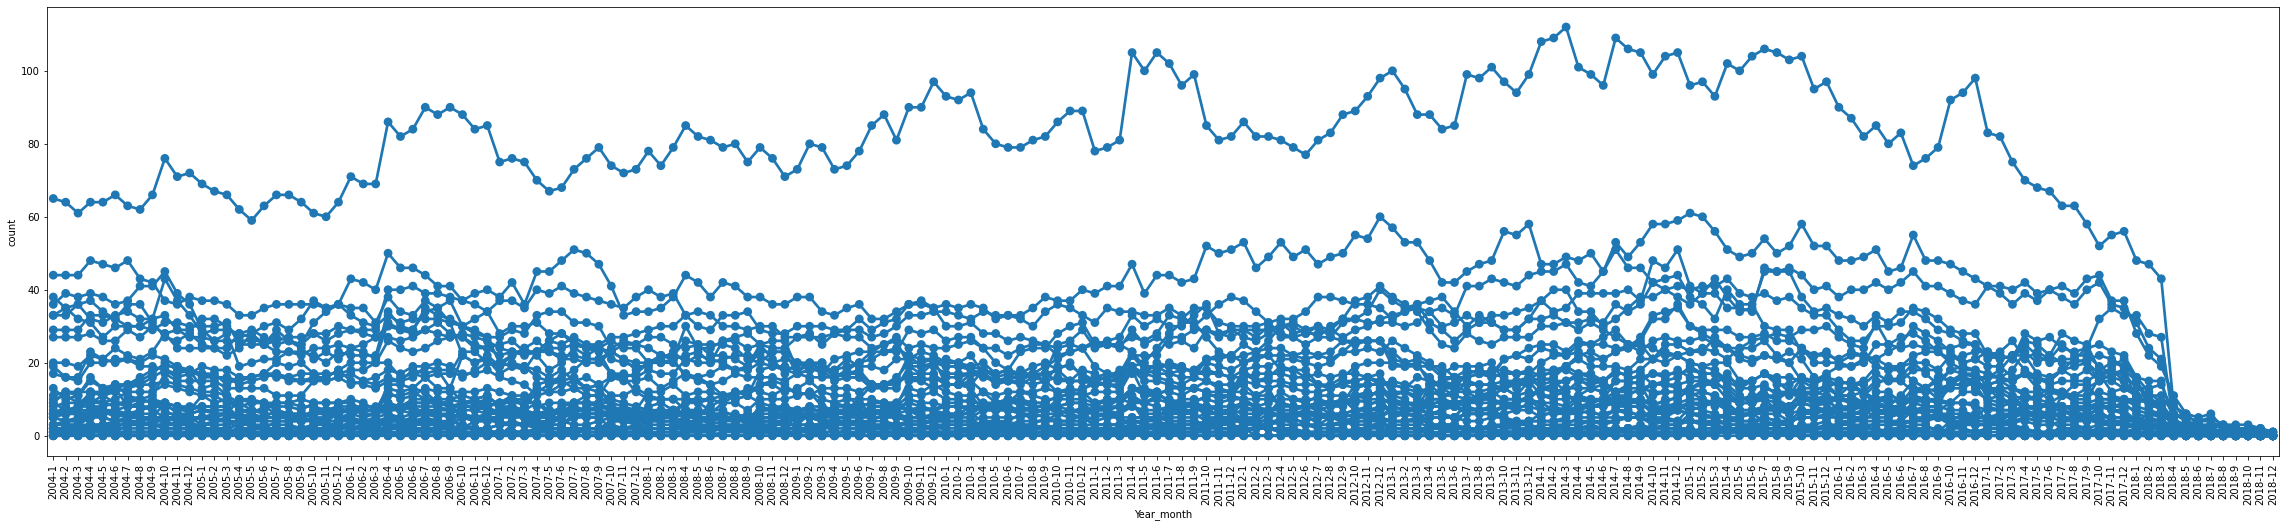

In [132]:


a4_dims = (40, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

for genre in genre_df.iloc[:,2:46]:
    sns.pointplot(data = genre_df, x = "Year_month", y = genre, ax=ax, label = genre)
#ax.legend()
plt.ylabel("count")
plt.xticks(rotation=90);

## Group by year and remake plot

In [20]:
genre_year = genre_df.drop(["Month"], axis=1).groupby("Year")

In [57]:
genre_year.sum()

,MartialArts,Ecchi,Drama,Harem,Kids,Action,Thriller,Psychological,Comedy,Parody,...,NA,SliceofLife,Military,Sports,ShounenAi,Space,ShoujoAi,Shounen,Hentai,Police
Year,,,,,,,,,,,,,,,,,,,,,
2004,60,112,393,81,232,465,16,87,794,36,...,0,156,101,60,5,88,27,366,389,50
2005,19,84,347,65,200,319,15,32,767,60,...,0,161,66,54,17,59,8,332,292,10
2006,49,88,381,59,291,440,12,59,986,106,...,0,199,77,70,18,39,16,331,319,10
2007,71,72,322,60,271,510,23,52,878,85,...,0,198,74,67,0,56,15,267,301,17
2008,48,116,195,61,280,462,33,59,939,147,...,0,185,63,38,15,36,14,241,365,27
2009,78,160,201,96,263,420,33,50,988,136,...,0,238,66,88,0,30,26,256,352,7
2010,71,194,190,110,236,427,12,16,1028,97,...,0,230,96,80,9,21,5,270,399,4
2011,41,174,220,109,208,533,22,31,1093,118,...,2,285,44,87,13,22,18,359,405,26
2012,60,157,219,88,250,616,7,31,1019,120,...,0,350,68,115,3,49,13,374,420,25


In [32]:
martial_arts = genre_year["MartialArts"].sum()

In [38]:
martial_arts.index
martial_arts.values

array([60, 19, 49, 71, 48, 78, 71, 41, 60, 65, 72, 65, 75, 59, 11])

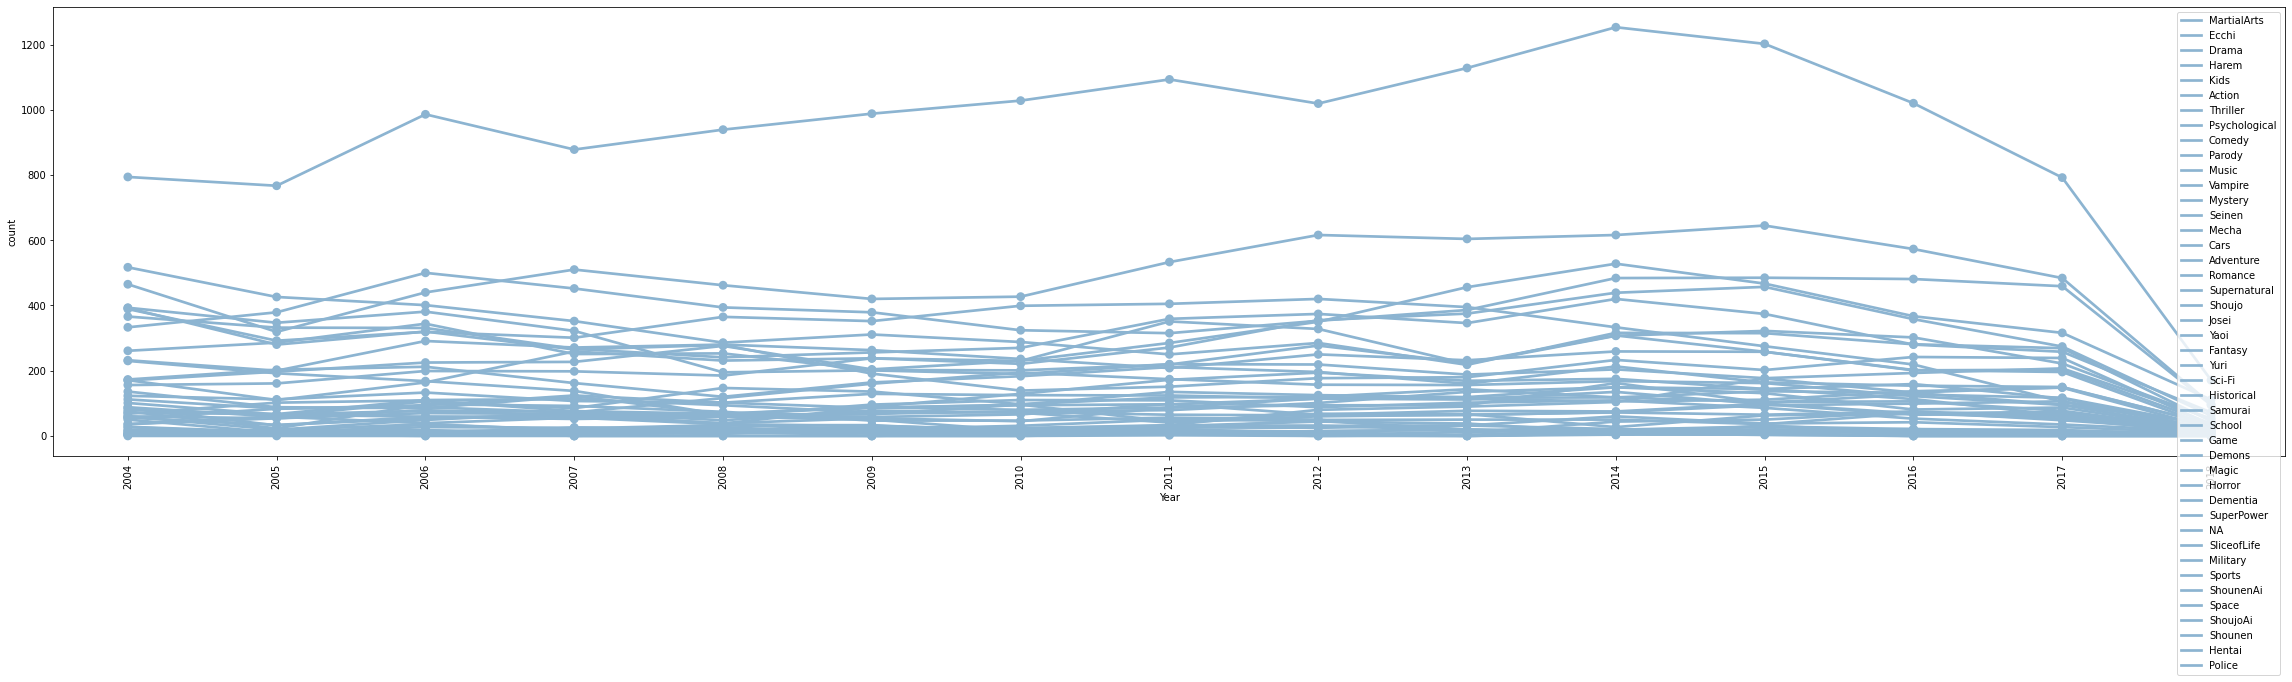

In [106]:
a4_dims = (40, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
all_genres = []


for genre in genre_year.sum():
    #print(genre)
    time = genre_year.sum()[genre].index
    values = genre_year.sum()[genre]
    rgb = (np.random.random(), np.random.random(), np.random.random())
    sns.pointplot(x = time, y = values,ax=ax, label = genre)
    all_genres.append(genre)

plt.legend(all_genres)
plt.ylabel("count")
plt.xticks(rotation=90);